In [1]:
# Import all packages

import openpyxl as opx
from ortools.linear_solver import pywraplp as glp
import lptools as lpt
import matplotlib.pyplot as plt
import statistics as st

In [2]:
# Read in excel worksheet

wb = opx.load_workbook('CRS_data.xlsx')

In [3]:
#wb.sheetnames

In [4]:
# Read Forecasted Demand and creat dictionary

Forecasted_Demand = wb['Forecasted Demand']
demand = dict()
for row in Forecasted_Demand.values:
    (zone, dmd) = row
    demand[zone] = dmd
# remove column names
del demand['Customer Zone']

In [5]:
#demand

In [6]:
# Read Annual_Plant_Capacity

Annual_Plant_Capacity = wb['Annual Plant Capacity']
plant = dict()
for row in Annual_Plant_Capacity.values:
    (plant_loc, capacity) = row
    plant[plant_loc] = capacity
# remove column names
del plant['Plant']
#plant

In [7]:
# Read Inbound_Freight_Costs

Inbound_Freight_Costs = wb['Inbound Freight Costs']
inbound_freight_costs = dict()
for row in Inbound_Freight_Costs.values:
    (candidate, Trenton, Stockton) = row
    if candidate != None:
        inbound_freight_costs[candidate] = (Trenton, Stockton)
#     (plant_loc, capacity) = row
#     plant[plant_loc] = capacity
del inbound_freight_costs['DC Candidates']

#inbound_freight_costs

In [8]:
# Read Handling_Charges

Handling_Charges =  wb['Handling Charges']
handle_costs = dict()
for row in Handling_Charges.values:
    (DC, Cost) = row
    handle_costs[DC] = Cost
    
del handle_costs['DC']
#handle_costs

In [9]:
# Read Outbound_Freight_Cost

Outbound_Freight_Cost = wb['Outbound Freight Cost']
outbound_freight_costs = dict()
for row in Outbound_Freight_Cost.values:
    #print(row)
    costs_list = list(row)
    #print(costs_list)
    DC = costs_list[0]
    
    costs_list.pop(0)
    data = costs_list
    if DC != None:
        outbound_freight_costs[DC] = tuple(data)
    
del outbound_freight_costs['DC']
#outbound_freight_costs

In [10]:
# Read in Transit times

Transit_Time = wb['Transit Time']
transit_time = dict()

for row in Transit_Time.values:
    #print(row)
    costs_list = list(row)
    #print(costs_list)
    city = costs_list[0]
    
    costs_list.pop(0)
    data = costs_list
    if city != None:
        transit_time[city] = tuple(data)
    
# del outbound_freight_costs['DC']
#transit_time

In [11]:
# Make the model
mymodel = glp.Solver('CRS', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [12]:
# Get Source Shipping costs
Trenton_costs = []
Stockton_costs = []

for item in inbound_freight_costs:
    (trenton, stockton) = inbound_freight_costs[item]
    h_cost = handle_costs[item]
    # Add the handeling costs to the inbound freight costs, will be included in the shipping costs
    Trenton_costs.append(trenton + h_cost)
    Stockton_costs.append(stockton + h_cost)
#print(Trenton_costs)
#print(Stockton_costs)

In [13]:
# Create a dictionary for transit times from the DC to the zone
DC_Transit = dict()

for time in transit_time:
    times = transit_time[time]
    for (zone,ship_time) in zip(demand,times):
        DC_Time = str(time) + "." + str(zone)
        DC_Transit[DC_Time] = ship_time


In [14]:
inf = mymodel.infinity()

In [15]:
# Create source costs
# name: supply capacity, objective coefficient list
source = {'Trenton': (plant['Trenton'] , Trenton_costs),    #
          'Stockton': (plant['Stockton'] , Stockton_costs),
         }  
#source

In [16]:
# name: supply capacity, objective coefficient list
transship = dict()

for row in outbound_freight_costs:
    #print(row)
    ship_costs = list(outbound_freight_costs[row])
    # Capacity of the handeling centers will just be both the plant capcities mutiplied by 2, no capacity cap for DC's
    transship[row] = (10000000 * 2 , ship_costs)
    
#transship

In [17]:
#demand # customer demand

In [18]:
mymodel.Objective().SetMinimization()    # minimize total plant and transportation cost

In [19]:
# create binary DC selection variables and a dictionary to access them
select = dict()
for t in transship:
    select[t] = mymodel.IntVar(0,1,t)
    (f, coeff_lst) = transship[t]
    mymodel.Objective().SetCoefficient(select[t], 0)

In [20]:
lpt.print_model(mymodel)

Variables:
Atlanta, Charleston, Charlotte, Chattanooga, Chicago, Cincinnati, Dallas, Denver, Greenville, Indianapolis, Knoxville, Louisville, Memphis, Nashville, Pittsburgh 

minimize: 

Subject To:

Bounds:
Atlanta in [0, 1]
Charleston in [0, 1]
Charlotte in [0, 1]
Chattanooga in [0, 1]
Chicago in [0, 1]
Cincinnati in [0, 1]
Dallas in [0, 1]
Denver in [0, 1]
Greenville in [0, 1]
Indianapolis in [0, 1]
Knoxville in [0, 1]
Louisville in [0, 1]
Memphis in [0, 1]
Nashville in [0, 1]
Pittsburgh in [0, 1]


In [21]:
# create inbound shipment variables from suppliers to dcs and a dictionary to access them
ship = dict()
for s in source:
    ship[s] = dict()
    (b,coeff_lst) = source[s]
    for (t,c) in zip(transship,coeff_lst):
        ship[s][t] = mymodel.NumVar(0,inf, s + "." + t)
        #ship[s][t] = mymodel.IntVar(0,1,s + "." + t)
        mymodel.Objective().SetCoefficient(ship[s][t], c)

In [22]:
#print(ship)

In [23]:
#lpt.print_model(mymodel)

In [24]:
# create source/supply constraints if the DC is chosen
for t in transship:
    (b, coeff_lst) = transship[t]
    constr = mymodel.Constraint(-inf ,0 ,t )
    constr.SetCoefficient(select[t] , -b)
    for s in source:
        constr.SetCoefficient(ship[s][t], 1)

In [25]:
#lpt.print_model(mymodel)

In [26]:
# At most X DC centers, constraint for limiting the amount of DC's that are chosen in the problem

max_dc = 15

constr = mymodel.Constraint(-inf ,max_dc ,"Max_DC")
for t in transship:
    constr.SetCoefficient(select[t] , 1)

In [27]:
#lpt.print_model(mymodel)

In [28]:
# create outbound shipment variables from DCs to Customers and a dictionary to access them
for t in transship:
    ship[t] = dict()
    (b,coeff_lst) = transship[t]
    for (d,c) in zip(demand,coeff_lst):
        ship[t][d] = mymodel.NumVar(0,inf,str(t) + "." + str(d) )
        mymodel.Objective().SetCoefficient(ship[t][d], c)

In [29]:
#lpt.print_model(mymodel)

In [30]:
#print(ship)

In [31]:
# create source/supply constraints
for s in source:
    (b,coeff_lst) = source[s]
    constr = mymodel.Constraint(-inf,b,s )
    for t in transship:
        plant_city = ship[s][t]
        constr.SetCoefficient(plant_city, 1)
        
# create DC capacity
for t in transship:
    (b,coeff_lst) = transship[t]
    constr = mymodel.Constraint(-inf,b, "link" + t )
    for s in source:
        constr.SetCoefficient(ship[s][t], 1)

In [32]:
#lpt.print_model(mymodel)

In [33]:
# create demand constraints
for d in demand:
    lb = ub = demand[d]
    constr = mymodel.Constraint(lb,ub,str(d))
    for t in transship:
        constr.SetCoefficient(ship[t][d], 1)

In [34]:
#lpt.print_model(mymodel)

In [35]:
# create transshipment flow balance constraints
for t in transship:
    constr = mymodel.Constraint(0,0,"flow" + t )
    for s in source:
        constr.SetCoefficient(ship[s][t], 1)
    for d in demand:
        constr.SetCoefficient(ship[t][d], -1)

In [36]:
#lpt.print_model(mymodel)

In [37]:
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f' % mymodel.Objective().Value())

optimal_value1 = mymodel.Objective().Value()
for v in mymodel.variables():
    print('%s = %.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 11464957.93
Atlanta = 1.00
Charleston = 1.00
Charlotte = 1.00
Chattanooga = 1.00
Chicago = 1.00
Cincinnati = 1.00
Dallas = 1.00
Denver = 1.00
Greenville = 1.00
Indianapolis = 1.00
Knoxville = 1.00
Louisville = 1.00
Memphis = 1.00
Nashville = 1.00
Pittsburgh = 1.00
Trenton.Atlanta = 368717.00
Trenton.Charleston = 1635612.00
Trenton.Charlotte = 268921.00
Trenton.Chattanooga = 0.00
Trenton.Chicago = 0.00
Trenton.Cincinnati = 0.00
Trenton.Dallas = 0.00
Trenton.Denver = 0.00
Trenton.Greenville = 2713823.00
Trenton.Indianapolis = 3656935.00
Trenton.Knoxville = 130354.00
Trenton.Louisville = 0.00
Trenton.Memphis = 0.00
Trenton.Nashville = 133476.00
Trenton.Pittsburgh = 1092162.00
Stockton.Atlanta = 0.00
Stockton.Charleston = 0.00
Stockton.Charlotte = 0.00
Stockton.Chattanooga = 0.00
Stockton.Chicago = 513058.00
Stockton.Cincinnati = 0.00
Stockton.Dallas = 3298787.00
Stockton.Denver = 2887655.00
Stockton.Greenville = 0.00
Stockton.Indianapolis = 0.00
Stockto

Chattanooga.362 = 0.00
Chattanooga.363 = 0.00
Chattanooga.364 = 0.00
Chattanooga.366 = 0.00
Chattanooga.367 = 0.00
Chattanooga.368 = 0.00
Chattanooga.370 = 0.00
Chattanooga.371 = 0.00
Chattanooga.372 = 0.00
Chattanooga.373 = 0.00
Chattanooga.374 = 0.00
Chattanooga.376 = 0.00
Chattanooga.379 = 0.00
Chattanooga.380 = 0.00
Chattanooga.381 = 0.00
Chattanooga.383 = 0.00
Chattanooga.384 = 0.00
Chattanooga.386 = 0.00
Chattanooga.387 = 0.00
Chattanooga.391 = 0.00
Chattanooga.392 = 0.00
Chattanooga.393 = 0.00
Chattanooga.394 = 0.00
Chattanooga.395 = 0.00
Chattanooga.396 = 0.00
Chattanooga.397 = 0.00
Chattanooga.402 = 0.00
Chattanooga.403 = 0.00
Chattanooga.405 = 0.00
Chattanooga.407 = 0.00
Chattanooga.410 = 0.00
Chattanooga.415 = 0.00
Chattanooga.416 = 0.00
Chattanooga.417 = 0.00
Chattanooga.420 = 0.00
Chattanooga.421 = 0.00
Chattanooga.422 = 0.00
Chattanooga.423 = 0.00
Chattanooga.424 = 0.00
Chattanooga.425 = 0.00
Chattanooga.427 = 0.00
Chattanooga.430 = 0.00
Chattanooga.431 = 0.00
Chattanooga

Cincinnati.344 = 0.00
Cincinnati.346 = 0.00
Cincinnati.347 = 0.00
Cincinnati.349 = 0.00
Cincinnati.350 = 0.00
Cincinnati.352 = 0.00
Cincinnati.356 = 0.00
Cincinnati.358 = 0.00
Cincinnati.359 = 0.00
Cincinnati.360 = 0.00
Cincinnati.361 = 0.00
Cincinnati.362 = 0.00
Cincinnati.363 = 0.00
Cincinnati.364 = 0.00
Cincinnati.366 = 0.00
Cincinnati.367 = 0.00
Cincinnati.368 = 0.00
Cincinnati.370 = 0.00
Cincinnati.371 = 0.00
Cincinnati.372 = 0.00
Cincinnati.373 = 0.00
Cincinnati.374 = 0.00
Cincinnati.376 = 0.00
Cincinnati.379 = 0.00
Cincinnati.380 = 0.00
Cincinnati.381 = 0.00
Cincinnati.383 = 0.00
Cincinnati.384 = 0.00
Cincinnati.386 = 0.00
Cincinnati.387 = 0.00
Cincinnati.391 = 0.00
Cincinnati.392 = 0.00
Cincinnati.393 = 0.00
Cincinnati.394 = 0.00
Cincinnati.395 = 0.00
Cincinnati.396 = 0.00
Cincinnati.397 = 0.00
Cincinnati.402 = 0.00
Cincinnati.403 = 0.00
Cincinnati.405 = 0.00
Cincinnati.407 = 0.00
Cincinnati.410 = 0.00
Cincinnati.415 = 0.00
Cincinnati.416 = 0.00
Cincinnati.417 = 0.00
Cincinnati

Greenville.86 = 0.00
Greenville.88 = 0.00
Greenville.100 = 0.00
Greenville.104 = 25322.00
Greenville.105 = 21088.00
Greenville.107 = 13997.00
Greenville.109 = 0.00
Greenville.110 = 40665.00
Greenville.112 = 0.00
Greenville.113 = 0.00
Greenville.115 = 51258.00
Greenville.117 = 87458.00
Greenville.120 = 0.00
Greenville.121 = 0.00
Greenville.122 = 0.00
Greenville.123 = 0.00
Greenville.125 = 0.00
Greenville.127 = 0.00
Greenville.128 = 0.00
Greenville.130 = 0.00
Greenville.132 = 0.00
Greenville.133 = 0.00
Greenville.135 = 0.00
Greenville.136 = 0.00
Greenville.137 = 0.00
Greenville.140 = 0.00
Greenville.142 = 0.00
Greenville.144 = 0.00
Greenville.146 = 0.00
Greenville.148 = 0.00
Greenville.149 = 0.00
Greenville.150 = 0.00
Greenville.151 = 0.00
Greenville.152 = 0.00
Greenville.153 = 0.00
Greenville.158 = 0.00
Greenville.161 = 0.00
Greenville.162 = 0.00
Greenville.163 = 0.00
Greenville.165 = 0.00
Greenville.166 = 0.00
Greenville.170 = 0.00
Greenville.171 = 0.00
Greenville.174 = 0.00
Greenville

Knoxville.307 = 12605.00
Knoxville.309 = 0.00
Knoxville.310 = 0.00
Knoxville.312 = 0.00
Knoxville.315 = 0.00
Knoxville.317 = 0.00
Knoxville.319 = 0.00
Knoxville.320 = 0.00
Knoxville.321 = 0.00
Knoxville.322 = 0.00
Knoxville.323 = 0.00
Knoxville.324 = 0.00
Knoxville.325 = 0.00
Knoxville.326 = 0.00
Knoxville.327 = 0.00
Knoxville.329 = 0.00
Knoxville.330 = 0.00
Knoxville.331 = 0.00
Knoxville.333 = 0.00
Knoxville.334 = 0.00
Knoxville.335 = 0.00
Knoxville.336 = 0.00
Knoxville.337 = 0.00
Knoxville.338 = 0.00
Knoxville.339 = 0.00
Knoxville.342 = 0.00
Knoxville.344 = 0.00
Knoxville.346 = 0.00
Knoxville.347 = 0.00
Knoxville.349 = 0.00
Knoxville.350 = 0.00
Knoxville.352 = 0.00
Knoxville.356 = 0.00
Knoxville.358 = 0.00
Knoxville.359 = 0.00
Knoxville.360 = 0.00
Knoxville.361 = 0.00
Knoxville.362 = 0.00
Knoxville.363 = 0.00
Knoxville.364 = 0.00
Knoxville.366 = 0.00
Knoxville.367 = 15240.00
Knoxville.368 = 0.00
Knoxville.370 = 0.00
Knoxville.371 = 0.00
Knoxville.372 = 0.00
Knoxville.373 = 30898.00
K

Nashville.285 = 0.00
Nashville.286 = 0.00
Nashville.287 = 0.00
Nashville.291 = 0.00
Nashville.292 = 0.00
Nashville.294 = 0.00
Nashville.295 = 0.00
Nashville.296 = 0.00
Nashville.300 = 0.00
Nashville.301 = 0.00
Nashville.302 = 0.00
Nashville.303 = 0.00
Nashville.304 = 0.00
Nashville.305 = 0.00
Nashville.306 = 0.00
Nashville.307 = 0.00
Nashville.309 = 0.00
Nashville.310 = 0.00
Nashville.312 = 0.00
Nashville.315 = 0.00
Nashville.317 = 0.00
Nashville.319 = 0.00
Nashville.320 = 0.00
Nashville.321 = 0.00
Nashville.322 = 0.00
Nashville.323 = 0.00
Nashville.324 = 0.00
Nashville.325 = 0.00
Nashville.326 = 0.00
Nashville.327 = 0.00
Nashville.329 = 0.00
Nashville.330 = 0.00
Nashville.331 = 0.00
Nashville.333 = 0.00
Nashville.334 = 0.00
Nashville.335 = 0.00
Nashville.336 = 0.00
Nashville.337 = 0.00
Nashville.338 = 0.00
Nashville.339 = 0.00
Nashville.342 = 0.00
Nashville.344 = 0.00
Nashville.346 = 0.00
Nashville.347 = 0.00
Nashville.349 = 0.00
Nashville.350 = 0.00
Nashville.352 = 0.00
Nashville.356

In [38]:
# None zero
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))

Atlanta =  1.00
Charleston =  1.00
Charlotte =  1.00
Chattanooga =  1.00
Chicago =  1.00
Cincinnati =  1.00
 Dallas =  1.00
 Denver =  1.00
Greenville =  1.00
Indianapolis =  1.00
Knoxville =  1.00
Louisville =  1.00
Memphis =  1.00
Nashville =  1.00
Pittsburgh =  1.00
Trenton.Atlanta = 368717.00
Trenton.Charleston = 1635612.00
Trenton.Charlotte = 268921.00
Trenton.Greenville = 2713823.00
Trenton.Indianapolis = 3656935.00
Trenton.Knoxville = 130354.00
Trenton.Nashville = 133476.00
Trenton.Pittsburgh = 1092162.00
Stockton.Chicago = 513058.00
Stockton.Dallas = 3298787.00
Stockton.Denver = 2887655.00
Stockton.Memphis = 325415.00
Stockton.Nashville = 29774.00
Atlanta.317 = 22191.00
Atlanta.319 = 24662.00
Atlanta.323 = 18889.00
Atlanta.324 = 40284.00
Atlanta.330 = 63020.00
Atlanta.331 = 79892.00
Atlanta.344 = 24796.00
Atlanta.350 = 16667.00
Atlanta.360 = 13051.00
Atlanta.361 = 31600.00
Atlanta.364 = 17077.00
Atlanta.368 = 16588.00
Charleston.10 = 33081.00
Charleston.12 = 18595.00
Charleston

Indianapolis.560 = 22511.00
Indianapolis.562 = 15919.00
Indianapolis.563 = 23353.00
Indianapolis.600 = 118259.00
Indianapolis.601 = 196539.00
Indianapolis.603 = 23137.00
Indianapolis.604 = 78538.00
Indianapolis.605 = 47256.00
Indianapolis.606 = 112487.00
Indianapolis.611 = 21588.00
Indianapolis.616 = 49875.00
Indianapolis.617 = 18861.00
Indianapolis.620 = 15676.00
Indianapolis.622 = 15933.00
Indianapolis.624 = 15503.00
Indianapolis.628 = 20557.00
Indianapolis.629 = 34857.00
Indianapolis.631 = 74522.00
Indianapolis.636 = 11030.00
Knoxville.307 = 12605.00
Knoxville.367 = 15240.00
Knoxville.373 = 30898.00
Knoxville.397 = 11307.00
Knoxville.407 = 10669.00
Knoxville.421 = 22066.00
Knoxville.422 = 12959.00
Knoxville.425 = 14610.00
Memphis.380 = 16687.00
Memphis.386 = 54410.00
Memphis.387 = 10587.00
Memphis.391 = 21222.00
Memphis.392 = 33900.00
Memphis.396 = 17273.00
Memphis.638 = 13987.00
Memphis.648 = 10899.00
Memphis.667 = 14666.00
Memphis.704 = 35641.00
Memphis.716 = 24663.00
Memphis.720 

Question 2

In [40]:
# Create a list of the all the transit time from the DC to the zone, take the average

shipping_times = []

for v in mymodel.variables():
    if v.solution_value() != 0:
        if v.name() in DC_Transit:
            shiptime = DC_Transit[v.name()]
            for i in range(int(v.solution_value())):
                shipping_times.append(shiptime)
                
print(sum(1 for x in shipping_times if x <= 2) / len(shipping_times))

0.8261166232514036


In [42]:
# Increasing max DCs and see how the optimal value and transit times are affected

# parameter analysis for Cutting_Time
param_lst =list(range(1,11))

optval_lst = []
customer_levels = []

constr = mymodel.constraints()[15]
for b in param_lst:
    constr.SetUb(b)
    mymodel.Solve()
    # Get optimal solution for number of DC's
    cost = mymodel.Objective().Value()
    shipping_times = []

    # Get customer service levels for DC's
    for v in mymodel.variables():
        if v.solution_value() != 0:
            if v.name() in DC_Transit:
                shiptime = DC_Transit[v.name()]
                for i in range(int(v.solution_value())):
                    shipping_times.append(shiptime)
                    
    customer_levels.append(sum(1 for x in shipping_times if x <= 2) / len(shipping_times)) 
    optval_lst.append(cost)
    
    

[13027743.920000015, 12160392.94000001, 11881486.929999998, 11649513.06, 11567265.77999999, 11540776.379999995, 11517942.129999995, 11498474.349999998, 11484900.249999998, 11473181.92]


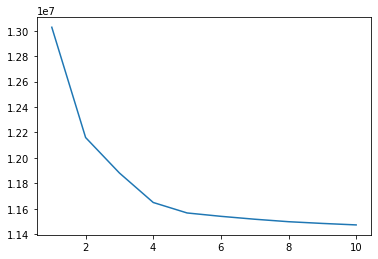

In [43]:
plt.plot(param_lst,optval_lst)
print(optval_lst)

[0.5987841772413159, 0.6970259420904927, 0.7471017096068321, 0.8094282817375511, 0.8213466330304321, 0.8169626020485705, 0.8228974148008188, 0.8229845362163678, 0.8239858482946237, 0.8239858482946237]


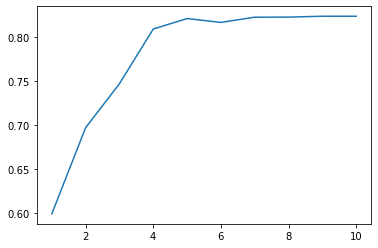

In [44]:
plt.plot(param_lst,customer_levels)
print(customer_levels)